In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from yellowbrick.classifier import roc_auc
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sns.set_style('dark')
%matplotlib inline
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
os.getcwd()

'/content'

In [3]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [4]:
# This function will provide result to our classification model
def validate_result(y_true, y_pred,y_prob,model="Model"):
    print(f"\nThe Result for the {model} Classification is as follows\n")
    print("=="*50)
    print(f"Recall Score: {(recall_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print(f"Precision Score: {(precision_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print("F1 Score: ",f1_score(y_true, y_pred,average='weighted').round(3))
    print("Log Loss: ",log_loss(y_true, y_prob).round(3))

In [5]:
data = pd.read_csv('./sample_data/mozilla_bugs.csv')

In [6]:
data.head()

,Type,Summary,Product,Component,Priority,Classification,Team Name
0,defect,[trunk] Crash on startup (mozilla::ReadAheadLi...,Firefox,General,P1,Client Software,Frontend
1,defect,release-update-verify-config tasks failing for...,Release Engineering,Release Automation: Updates,P1,Other,RelEng
2,defect,Android workers not taking jobs.,Taskcluster,General,P1,Other,Mozilla
3,defect,browser/base/content/test/performance/browser_...,NSS,Libraries,P1,Components,Crypto
4,defect,Breakpoint positions are only fetched for some...,DevTools,Debugger,P1,Components,DevTools


In [7]:
data.shape #30000 records in total and 7 attributes

(30000, 7)

In [8]:
data.columns

Index(['Type', 'Summary', 'Product', 'Component', 'Priority', 'Classification',
       'Team Name'],
      dtype='object')

### Base Model Building And Prediction


#### Here we will use MLP for classification.

#### In addition to Team Name, we will also try to determine  Component and Classification based on the textual summary of the reported bug

#### We will create individual models for the same and test it out on Real World data for prediction

## Model Building MLP (With RandomizedSearchCV)

In [9]:
def build_model(data,column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns):
    print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(data.shape))
    print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(data[column_to_predict]))))
    bytag = data.groupby(column_to_predict).aggregate(np.count_nonzero)
    tags = bytag[bytag.Summary > min_data_per_class].index
    data = data[data[column_to_predict].isin(tags)]
    print(
            "Shape of dataset after removing classes with less then "
            + str(min_data_per_class) + " rows: "
            + str(data.shape)
        )
    print(
            "Number of classes after removing classes with less then "
            + str(min_data_per_class) + " rows: "
            + str(len(np.unique(data[column_to_predict])))
        )

    labelData = data[column_to_predict]
    data = data[text_columns]



    # Split dataset into training and testing data
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labelData, test_size=0.2
    )  # split data to train/test sets with 80:20 ratio

    # Extracting features from text
    # Count vectorizer
    if remove_stop_words:
        count_vect = CountVectorizer(stop_words=stop_words_lang)
    elif use_stemming:
        count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
    else:
        count_vect = CountVectorizer()

    # Fitting the training data into a data processing pipeline and eventually into the model itself

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MLPClassifier(hidden_layer_sizes=100, solver ='adam', early_stopping=True, learning_rate='adaptive',
                    validation_fraction=0.3,
                    n_iter_no_change=20,
                    verbose=True, random_state=1))
    ])

    text_clf = text_clf.fit(train_data, train_labels)

    parameters = {
    'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'clf__activation': ['tanh', 'relu']
    }
    
    print("Starting Random Search for hyperparameter tuning")
    rs_clf = RandomizedSearchCV(text_clf, parameters, n_jobs=-1, n_iter=10)
    rs_clf = rs_clf.fit(train_data, train_labels)
    
    print("Best Score:",rs_clf.best_score_)
    print("Best Params:", rs_clf.best_params_)
    print("Best Estimator:", rs_clf.best_estimator_)
    
    print("Evaluating model")
    # Score and evaluate model on test data using model without hyperparameter tuning
    predicted = text_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix without RandomizedSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean Accuracy without RandomizedSearch: " + str(prediction_acc))
    
    predicted = rs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with RandomizedSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean Accuracy with RandomizedSearch: " + str(prediction_acc))


    validate_result(test_labels,text_clf.predict(test_data),text_clf.predict_proba(test_data),model="MLP")


    # Ploting confusion matrix with 'seaborn' module

    mat = confusion_matrix(test_labels, predicted)
    plt.figure(figsize=(10, 10))
    sns.set()
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(test_labels),
                yticklabels=np.unique(test_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')

    # Save confusion matrix to outputs folder
    # plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
    plt.show()


    # Printing classification report
    # Use below line only with Jupyter Notebook

    print(classification_report(test_labels, predicted,
                                target_names=np.unique(test_labels)))
    
    

    #print("=="*50)
    #print("\nROC Curve\n")
    #print("=="*50)
    #fig_dims = (15, 6)
    #fig, ax = plt.subplots(figsize=fig_dims)
    #roc_auc(text_clf,train_data,train_labels,X_test = test_data, y_test = test_labels ,ax=ax)

    pickle.dump(
                rs_clf,
                open(os.path.join(
                    '.', 'sample_data', column_to_predict+"_NN_RS.model"),
                    'wb'
                )
            )

#### Build the model to predict Team Name

In [10]:
df2 = data.copy() #Keep a copy of original dataframe to ensure it can be used later. Dataframe data to be fed to the method

#Initialize parameters to be fed to the method for model building
column_to_predict = "Team Name"

#use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 100  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 100 rows: (30000, 7)
Number of classes before removing classes with less then 100 rows: 31
Shape of dataset after removing classes with less then 100 rows: (29848, 7)
Number of classes after removing classes with less then 100 rows: 27
Iteration 1, loss = 3.08960264
Validation score: 0.214964
Iteration 2, loss = 2.51805542
Validation score: 0.366415
Iteration 3, loss = 1.95465417
Validation score: 0.513680
Iteration 4, loss = 1.47680236
Validation score: 0.576633
Iteration 5, loss = 1.12532986
Validation score: 0.604830
Iteration 6, loss = 0.87305353
Validation score: 0.615997
Iteration 7, loss = 0.68934682
Validation score: 0.626605
Iteration 8, loss = 0.55316570
Validation score: 0.633166
Iteration 9, loss = 0.45232262
Validation score: 0.632328
Iteration 10, loss = 0.37550279
Validation score: 0.630374
Iteration 11, loss = 0.31689043
Validation score: 0.631491
Iteration 12, loss = 0.27101208
Validation score: 0.631351
Iteration

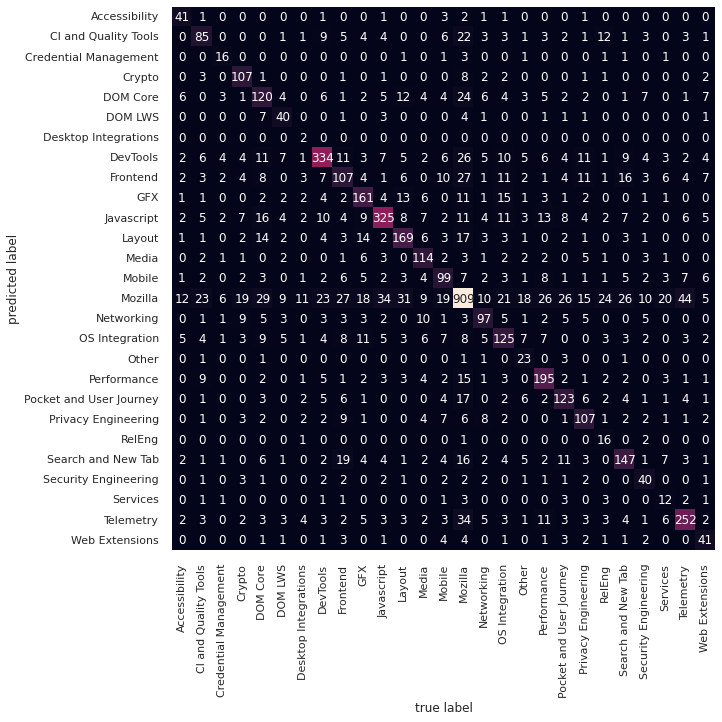

                         precision    recall  f1-score   support

          Accessibility       0.79      0.53      0.64        77
   CI and Quality Tools       0.50      0.55      0.52       155
  Credential Management       0.64      0.42      0.51        38
                 Crypto       0.83      0.64      0.72       167
               DOM Core       0.52      0.49      0.51       244
                DOM LWS       0.67      0.48      0.56        84
   Desktop Integrations       1.00      0.06      0.11        34
               DevTools       0.68      0.78      0.73       428
               Frontend       0.43      0.48      0.45       223
                    GFX       0.69      0.64      0.66       253
             Javascript       0.68      0.79      0.73       412
                 Layout       0.67      0.65      0.66       259
                  Media       0.75      0.63      0.69       180
                 Mobile       0.56      0.52      0.54       190
                Mozilla 

In [11]:
#Build Model
build_model(data, column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [13]:
#Load Model
model_Team_Name = pickle.load(
    open(
         os.getcwd()+"/sample_data/Team Name_NN_RS.model", "rb"
    )
)

#### Build the Model to predict Component

In [14]:
data = df2.copy() #restore original dataframe which got modified while creating last model
#Initialize parameters to be fed to the method for model building
column_to_predict = "Component"

#use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 50  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 50 rows: (30000, 7)
Number of classes before removing classes with less then 50 rows: 536
Shape of dataset after removing classes with less then 50 rows: (24724, 7)
Number of classes after removing classes with less then 50 rows: 126
Iteration 1, loss = 4.69773478
Validation score: 0.165993
Iteration 2, loss = 4.13870519
Validation score: 0.130603
Iteration 3, loss = 3.74204303
Validation score: 0.203236
Iteration 4, loss = 3.32367874
Validation score: 0.283451
Iteration 5, loss = 2.89078783
Validation score: 0.349343
Iteration 6, loss = 2.46962147
Validation score: 0.398045
Iteration 7, loss = 2.08635880
Validation score: 0.424334
Iteration 8, loss = 1.75215060
Validation score: 0.459724
Iteration 9, loss = 1.46755127
Validation score: 0.483654
Iteration 10, loss = 1.22840171
Validation score: 0.499494
Iteration 11, loss = 1.02967868
Validation score: 0.513650
Iteration 12, loss = 0.86522035
Validation score: 0.523930
Iteration 1

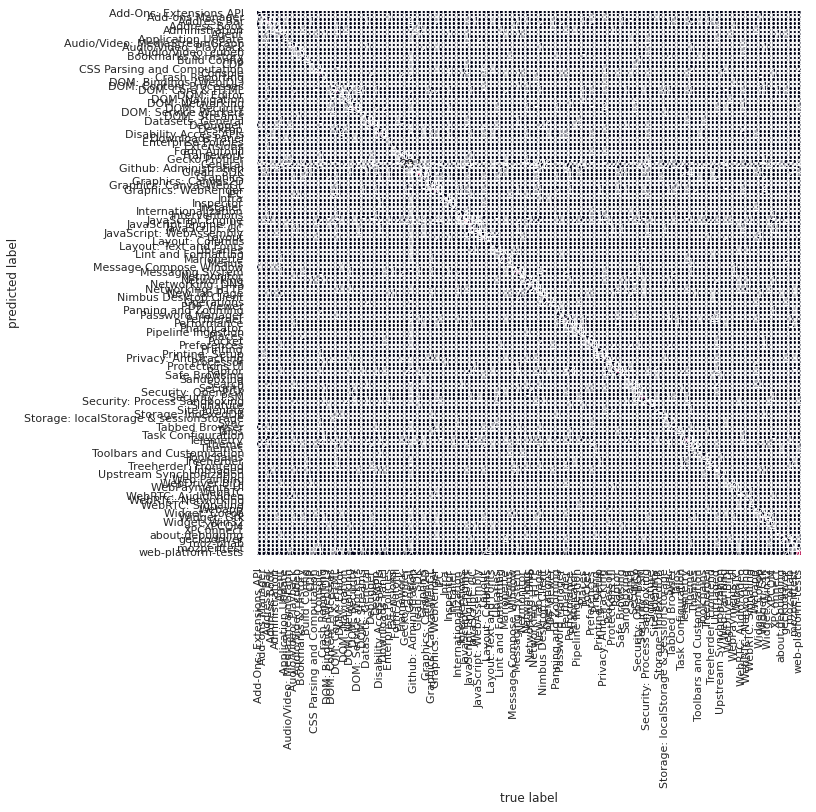

                                        precision    recall  f1-score   support

               Add-Ons: Extensions API       1.00      0.19      0.32        16
                       Add-ons Manager       0.45      0.31      0.37        16
                           Address Bar       0.66      0.72      0.69        95
                          Address Book       0.63      0.71      0.67        17
                        Administration       0.52      0.58      0.55        24
                                 Agent       0.52      0.57      0.54        30
                    Application Update       0.31      0.24      0.27        17
         Audio/Video: MediaStreamGraph       0.50      0.09      0.15        11
                 Audio/Video: Playback       0.71      0.67      0.69        52
                    Audio/Video: cubeb       0.81      0.76      0.79        17
                   Bookmarks & History       0.55      0.50      0.52        22
                          Build Config 

In [15]:
#Build Model
build_model(data, column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [16]:
#Load Model
model_Component = pickle.load(
    open(
         os.getcwd()+"/sample_data/Component_NN_RS.model", "rb"
    )
)

#### Build Model to predict Classification

In [17]:
data = df2.copy() #restore original dataframe which got modified while creating last model
#Initialize parameters to be fed to the method for model building
column_to_predict = "Classification"

#use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 10  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 10 rows: (30000, 7)
Number of classes before removing classes with less then 10 rows: 5
Shape of dataset after removing classes with less then 10 rows: (30000, 7)
Number of classes after removing classes with less then 10 rows: 5
Iteration 1, loss = 1.19441001
Validation score: 0.654722
Iteration 2, loss = 0.71746209
Validation score: 0.763889
Iteration 3, loss = 0.51815889
Validation score: 0.800000
Iteration 4, loss = 0.38753359
Validation score: 0.807917
Iteration 5, loss = 0.30034915
Validation score: 0.810694
Iteration 6, loss = 0.24273238
Validation score: 0.815000
Iteration 7, loss = 0.20297173
Validation score: 0.815417
Iteration 8, loss = 0.17454753
Validation score: 0.811667
Iteration 9, loss = 0.15278897
Validation score: 0.810417
Iteration 10, loss = 0.13637066
Validation score: 0.809028
Iteration 11, loss = 0.12347459
Validation score: 0.806111
Iteration 12, loss = 0.11206196
Validation score: 0.804028
Iteration 13, l

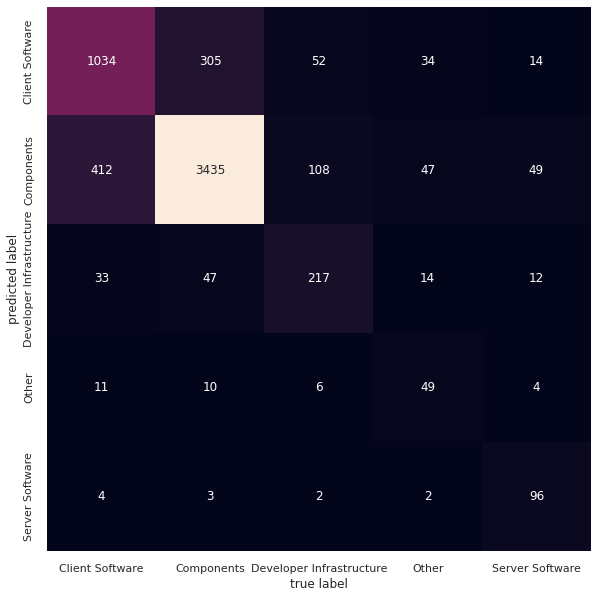

                          precision    recall  f1-score   support

         Client Software       0.72      0.69      0.71      1494
              Components       0.85      0.90      0.88      3800
Developer Infrastructure       0.67      0.56      0.61       385
                   Other       0.61      0.34      0.43       146
         Server Software       0.90      0.55      0.68       175

                accuracy                           0.81      6000
               macro avg       0.75      0.61      0.66      6000
            weighted avg       0.80      0.81      0.80      6000



In [18]:
#Build Model
build_model(data, column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [19]:
#Load Model
model_Classification = pickle.load(
    open(
         os.getcwd()+"/sample_data/Classification_NN_RS.model", "rb"
    )
)

#### Feed Random problem summary of support tickets to test predictions by the pre-trained models.

In [20]:
#Random sample input texts 'summarizing the issue' and fed to the models for testing
description1='Sync error while signing in to profile'
description2='details not appearing on locked device'
description3='Crash on toggle of settings on iPad'
description4='Unable to save credentials for email'
description5='Browser keeps crashing on opening multiple tabs' 
description6='Themes resulting in modified colors on the menubar'

In [21]:
#Team Name Model
predicted = model_Team_Name.predict([description1])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description2])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description3])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description4])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description5])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description6])
print("Predicted Team Name: " + str(predicted))

Predicted Team Name: ['Performance']
Predicted Team Name: ['Media']
Predicted Team Name: ['Mobile']
Predicted Team Name: ['Mozilla']
Predicted Team Name: ['Search and New Tab']
Predicted Team Name: ['Search and New Tab']


In [22]:
#Component Model
predicted = model_Component.predict([description1])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description2])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description3])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description4])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description5])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description6])
print("Predicted Component: " + str(predicted))

Predicted Component: ['Gecko Profiler']
Predicted Component: ['Sync']
Predicted Component: ['General']
Predicted Component: ['Untriaged']
Predicted Component: ['General']
Predicted Component: ['Theme']


In [23]:
#Classification Model
predicted = model_Classification.predict([description1])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description2])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description3])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description4])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description5])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description6])
print("Predicted Classification: " + str(predicted))

Predicted Classification: ['Components']
Predicted Classification: ['Components']
Predicted Classification: ['Components']
Predicted Classification: ['Developer Infrastructure']
Predicted Classification: ['Client Software']
Predicted Classification: ['Components']
